In [1]:
import pickle as pk
import numpy as np
from glob import glob

In [4]:
!mkdir /dev/shm/data
!ls /dev/shm

data


In [5]:
data_dir="/dev/shm/data"
#!rm $data_dir/patches*.npz
!ls -lrt $data_dir/patches*.npz


ls: cannot access '/dev/shm/data/patches*.npz': No such file or directory


In [11]:
s3files=!aws s3 ls s3://mousebraindata-open/MD657/patches/
s3files[:3]

['2018-10-09 21:42:43 1447758130 patches0.npz',
 '2018-10-09 21:43:25 1291505818 patches1.npz',
 '2018-10-09 21:49:28 1380666058 patches10.npz']

In [12]:
patches=np.zeros([0])
i=0
for line in s3files:
    parts=line.split()
    filename=parts[-1]
    print(filename)
    !aws s3 cp s3://mousebraindata-open/MD657/patches/$filename $data_dir

    file=data_dir+"/"+filename
    print(file)
    content=np.load(file)
    if patches.shape[0]==0:
        patches=content['Vout']
    else:
        patches=np.concatenate([patches,content['Vout']])
    print(i,patches.shape)
    i+=1
    !rm $file

patches0.npz
download: s3://mousebraindata-open/MD657/patches/patches0.npz to ../../../../dev/shm/data/patches0.npz
/dev/shm/data/patches0.npz
0 (107656, 41, 41)
patches1.npz
download: s3://mousebraindata-open/MD657/patches/patches1.npz to ../../../../dev/shm/data/patches1.npz
/dev/shm/data/patches1.npz
1 (203693, 41, 41)
patches10.npz
download: s3://mousebraindata-open/MD657/patches/patches10.npz to ../../../../dev/shm/data/patches10.npz
/dev/shm/data/patches10.npz
2 (306360, 41, 41)
patches100.npz
download: s3://mousebraindata-open/MD657/patches/patches100.npz to ../../../../dev/shm/data/patches100.npz
/dev/shm/data/patches100.npz
3 (426375, 41, 41)
patches101.npz
download: s3://mousebraindata-open/MD657/patches/patches101.npz to ../../../../dev/shm/data/patches101.npz
/dev/shm/data/patches101.npz
4 (533851, 41, 41)
patches102.npz
download: s3://mousebraindata-open/MD657/patches/patches102.npz to ../../../../dev/shm/data/patches102.npz
/dev/shm/data/patches102.npz
5 (632878, 41, 41)


patches141.npz
download: s3://mousebraindata-open/MD657/patches/patches141.npz to ../../../../dev/shm/data/patches141.npz
/dev/shm/data/patches141.npz
48 (4696593, 41, 41)
patches142.npz
download: s3://mousebraindata-open/MD657/patches/patches142.npz to ../../../../dev/shm/data/patches142.npz
/dev/shm/data/patches142.npz
49 (4795287, 41, 41)
patches143.npz
download: s3://mousebraindata-open/MD657/patches/patches143.npz to ../../../../dev/shm/data/patches143.npz
/dev/shm/data/patches143.npz
50 (4899826, 41, 41)
patches144.npz
download: s3://mousebraindata-open/MD657/patches/patches144.npz to ../../../../dev/shm/data/patches144.npz
/dev/shm/data/patches144.npz
51 (5003706, 41, 41)
patches145.npz
download: s3://mousebraindata-open/MD657/patches/patches145.npz to ../../../../dev/shm/data/patches145.npz
/dev/shm/data/patches145.npz
52 (5112427, 41, 41)
patches146.npz
download: s3://mousebraindata-open/MD657/patches/patches146.npz to ../../../../dev/shm/data/patches146.npz
/dev/shm/data/patc

download: s3://mousebraindata-open/MD657/patches/patches87.npz to ../../../../dev/shm/data/patches87.npz
/dev/shm/data/patches87.npz
144 (14699281, 41, 41)
patches88.npz
download: s3://mousebraindata-open/MD657/patches/patches88.npz to ../../../../dev/shm/data/patches88.npz
/dev/shm/data/patches88.npz


MemoryError: 

In [17]:
patches.size/1000000.
patches=patches[:10000000,:,:]
patches.shape

(10000000, 41, 41)

In [ ]:
def permute(data):
    shuffle=np.random.permutation(data.shape[0])
    return data[shuffle,:,:]
scombined=permute(patches)

In [22]:
patches=[]
scombined.shape

(10000000, 41, 41)

In [23]:
patches.shape

AttributeError: 'list' object has no attribute 'shape'

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve
gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)
factor=sum(gaussian)
print('factor=',factor)
def calc_err(pic):
    P=convolve(pic,gaussian)/factor
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

factor= 0.9994587918263369


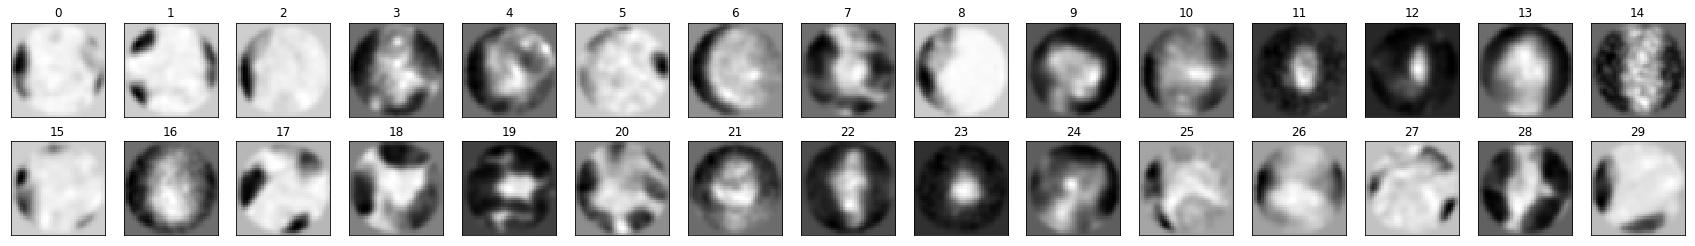

In [26]:
def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=data[i,:,:]
        P=convolve(pic,gaussian)/factor

        fig=imshow(P,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plot_patches(scombined,h=2,_titles=[str(i) for i in range(scombined.shape[0])])

In [27]:
def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

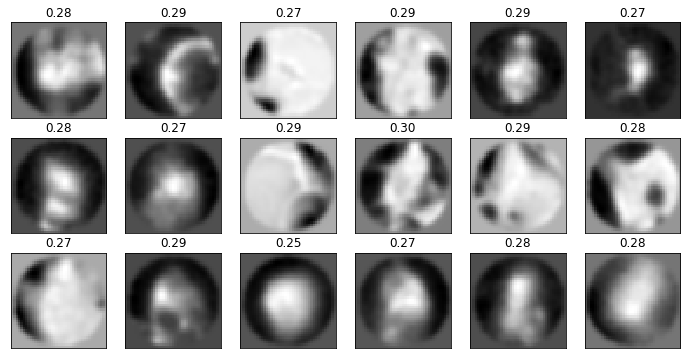

In [28]:
shift=1000
selected=[]
errors=[]
i=0; j=0;
while j < 50:
    pic=scombined[i+shift,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error>0.3:
        continue
    j+=1
    selected.append(pic)
    errors.append('%4.2f'%error)
plot_patches(pack_pics(selected),h=3,w=6,_titles=errors)

In [29]:
#collect images that are pretty smooth
# reduce resolution by a factor of 2
low_err=[]
i=0
while len(low_err) <1000000:
    if i >= scombined.shape[0]:
        break
    pic=scombined[i,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error<0.3:
        low_err.append(sub)
        j=len(low_err)
        if j%1000==0:
            print('\r',i,j,end='')

lcombined=np.stack(low_err)
lcombined.shape

 2219596 1000000

(1000000, 21, 21)

In [31]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [32]:
D=[]
for i in range(1,lcombined.shape[0]):
    D.append(dist2(lcombined[i,:,:],lcombined[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 999000

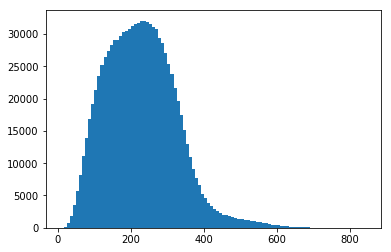

In [33]:
hist(D,bins=100);

In [34]:
max(D)

842.1696445815694

In [35]:
def refineKmeans(data,Reps):
    new_Reps=[np.zeros(Reps[0].shape) for r in Reps]
    Reps_count=[0.0 for r in Reps]
    error=0
    for i in range(data.shape[0]): 
        patch=data[i,:,:]
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
    error /= data.shape[0]
    for i in range(len(new_Reps)):
        new_Reps[i]/=Reps_count[i]
    return new_Reps,Reps_count,error

In [36]:
def Kmeans(data,n=100,scale=550):
    Reps,Statistics = Kmeanspp(data,n,scale)
    for i in range(5):
        Reps,error = refineKmeans(data,Reps)
        print('refine iteration %2d, error=%7.3f'%(i,error))

In [37]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    for i in range(1,data.shape[0]): 
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

In [38]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

 i=        31,  #reps=         9  Prob=0.247361

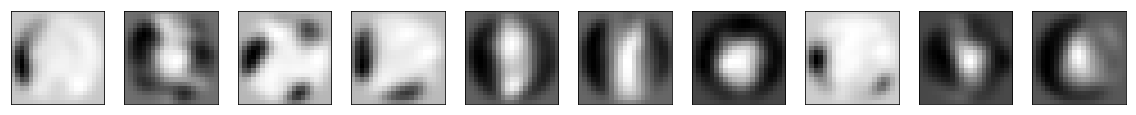

In [39]:
N=10
Reps, Statistics = Kmeanspp(lcombined,n=N)
Reps_mat = pack_pics(Reps)
plot_patches(Reps_mat,h=5,w=10)

116.18111285078568


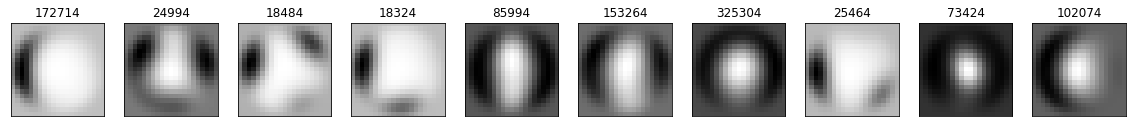

In [41]:
new_Reps,Reps_count,error = refineKmeans(lcombined[:100000],Reps)
print(error)
Reps_mat = pack_pics(new_Reps)

plot_patches(Reps_mat,h=5,w=10,_titles=['%d4'%x for x in Reps_count])

partition 0
 i=        35,  #reps=         9  Prob=0.176693partition 1
 i=        52,  #reps=         9  Prob=0.176972partition 2
 i=        24,  #reps=         9  Prob=0.087476partition 3
 i=        24,  #reps=         9  Prob=0.125031partition 4
 i=        36,  #reps=         9  Prob=0.140396partition 5
 i=        24,  #reps=         9  Prob=0.159211partition 6
 i=        28,  #reps=         9  Prob=0.142235partition 7
 i=        35,  #reps=         9  Prob=0.153914partition 8
 i=        30,  #reps=         9  Prob=0.163474partition 9
 i=        38,  #reps=         9  Prob=0.303893partition 10
 i=        40,  #reps=         9  Prob=0.249463partition 11
 i=        25,  #reps=         9  Prob=0.290764partition 12
 i=        44,  #reps=         9  Prob=0.141077partition 13
 i=        57,  #reps=         9  Prob=0.428180partition 14
 i=        17,  #reps=         9  Prob=0.126651partition 15
 i=        43,  #reps=         9  Prob=0.305004partition 16
 i=        38,  #reps=         9  Pro

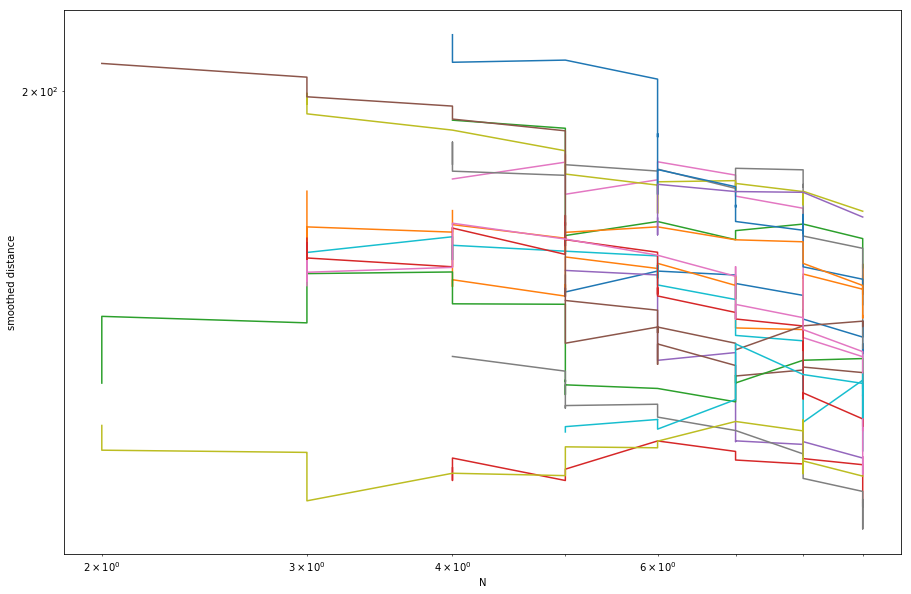

In [42]:
# Generate K different partitions

K=20 # number of independent partitions
N =10 # number of parts in each partition
Multi_Rep=[]
figure(figsize=[15,10])
for i in range(K):
    print('partition',i)
    lcombined=permute(lcombined)
    Reps, Statistics = Kmeanspp(lcombined,n=N)
    new_Reps,Reps_count,error = refineKmeans(lcombined[:100000],Reps)
    Multi_Rep.append(new_Reps)
    plot_statistics(Statistics)


In [43]:
len(Multi_Rep)

20

In [44]:
stacks=[]
for Rep in Multi_Rep:
    stacks.append(np.stack(Rep))
All=np.stack(stacks)
All.shape

(20, 10, 21, 21)

In [45]:
pic=np.zeros([1,1,21,21])

all_labels=[]

mean_vecs=np.zeros([])
for i in range(lcombined.shape[0]):
    pic[0,0,:,:]=lcombined[i,:,:]

    diff=(All-pic)**2
    dists=np.sum(np.sum(diff,axis=2),axis=2)
    labels=np.argmin(dists,axis=1)
    all_labels.append(tuple(labels))
    if i%1000==0:
        print('\r',i,end='')

 999000

In [46]:
len(all_labels[0])

20

In [47]:
from collections import Counter

def calc_entropy(all_labels,i=0,j=1,threshold=1):
    c=Counter([x[i:j] for x in all_labels])
    counts=np.array(list(c.values()),dtype=np.float)
    counts1=counts[counts>threshold]
    leftout=sum(counts)-sum(counts1)
    if leftout>0:
        counts1=np.concatenate([np.array([leftout]),counts1])
    P=counts1/sum(counts1)
    return np.sum(P*log(1/P)),counts1,c
#calc_entropy(all_labels,i=0,j=3)

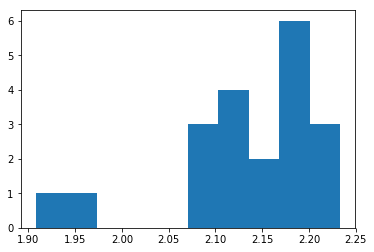

In [48]:
H=[]
for i in range(K):
    H.append(calc_entropy(all_labels,i=i,j=i+1)[0])

hist(H);

In [49]:
cumH=np.concatenate([np.zeros(1),cumsum(H)])
cumH

array([ 0.        ,  2.07764216,  4.23481376,  6.1781736 ,  8.2799496 ,
       10.47319843, 12.68179246, 14.91511255, 17.03199257, 19.12699568,
       21.32075569, 23.49713311, 25.65944518, 27.56728092, 29.69329552,
       31.8102215 , 34.00953169, 36.1440584 , 38.33956562, 40.5594285 ,
       42.7402156 ])

In [50]:
HC=[]
counts_vecs=[]
for i in range(K):
    H,counts,c=calc_entropy(all_labels,i=0,j=i)
    HC.append(H)
    counts_vecs.append(counts)

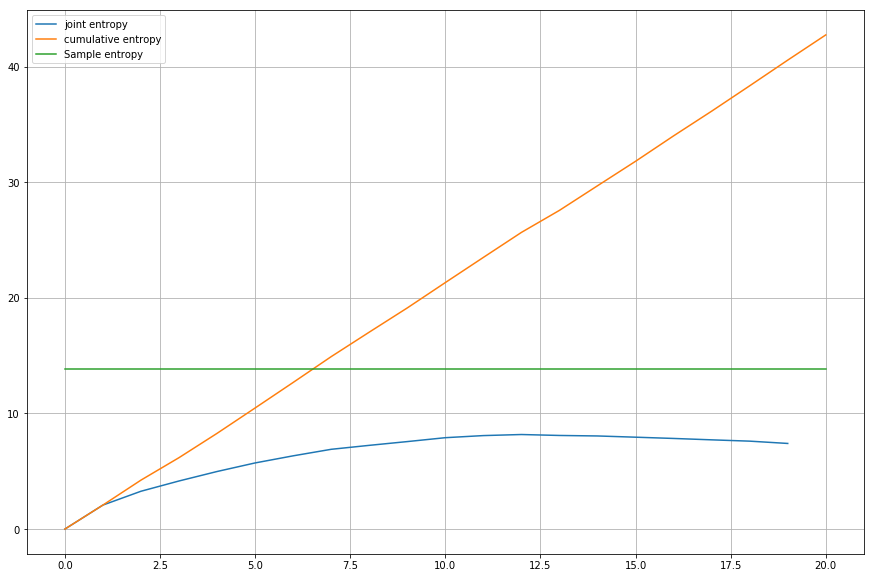

In [51]:
figure(figsize=[15,10])
j=K+1
plot(HC[:j],label='joint entropy')
plot(cumH[:j],label='cumulative entropy')
sample_H = log(len(all_labels))
plot([sample_H]*j,label='Sample entropy')
grid()
legend()

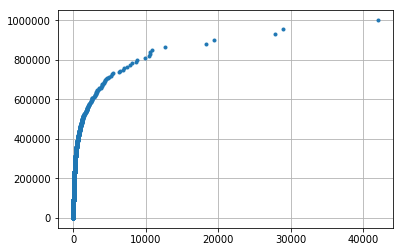

In [66]:
K1=7
H,counts,c=calc_entropy(all_labels,i=0,j=K1)

sc=sort(counts)
plot(sc,cumsum(sc),'.');
grid()

In [68]:
sc[-30:]

array([ 4222.,  4355.,  4397.,  4562.,  4687.,  4848.,  4859.,  5209.,
        5407.,  5444.,  6304.,  6383.,  6853.,  6961.,  7472.,  7844.,
        8125.,  8595.,  8818.,  9901., 10393., 10518., 10608., 10888.,
       12594., 18362., 19416., 27841., 28874., 41987.])

19
 999000620000
0 (5, 4, 0, 9, 2, 1, 8) (10608, 21, 21)
1 (1, 0, 0, 3, 2, 1, 9) (6961, 21, 21)
2 (1, 0, 0, 3, 9, 7, 2) (10518, 21, 21)
3 (9, 1, 4, 7, 0, 2, 1) (7844, 21, 21)
4 (8, 1, 4, 7, 4, 5, 6) (8818, 21, 21)
5 (1, 9, 0, 3, 9, 9, 2) (27841, 21, 21)
6 (1, 9, 0, 3, 9, 7, 2) (41987, 21, 21)
7 (7, 3, 8, 8, 7, 0, 3) (10888, 21, 21)
8 (5, 9, 0, 3, 9, 9, 2) (18362, 21, 21)
9 (4, 7, 7, 5, 3, 6, 7) (7472, 21, 21)
10 (9, 1, 4, 6, 0, 2, 1) (8595, 21, 21)
11 (5, 9, 0, 3, 2, 9, 4) (6853, 21, 21)
12 (8, 1, 4, 7, 0, 5, 1) (19416, 21, 21)
13 (7, 3, 8, 0, 7, 0, 3) (28874, 21, 21)
14 (1, 0, 0, 3, 2, 1, 8) (8125, 21, 21)
15 (8, 1, 4, 7, 0, 5, 6) (12594, 21, 21)
16 (8, 6, 4, 6, 4, 5, 6) (6383, 21, 21)
17 (5, 9, 0, 3, 9, 9, 4) (9901, 21, 21)
18 (1, 9, 0, 3, 6, 7, 2) (6304, 21, 21)


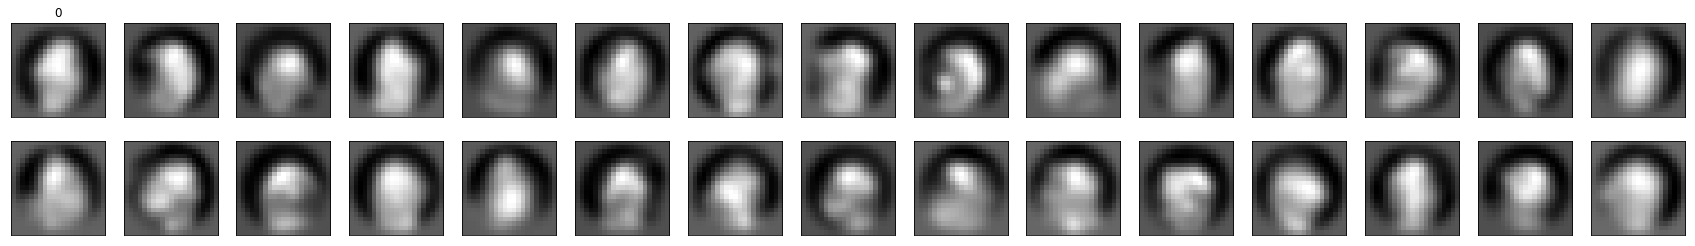

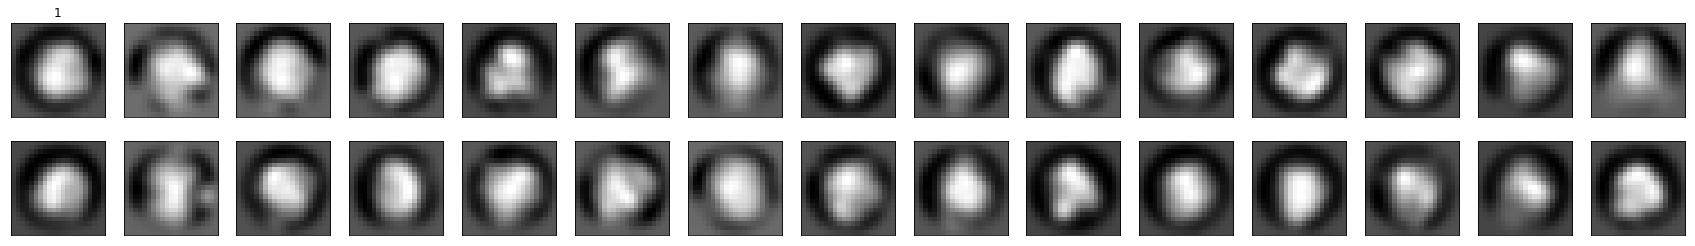

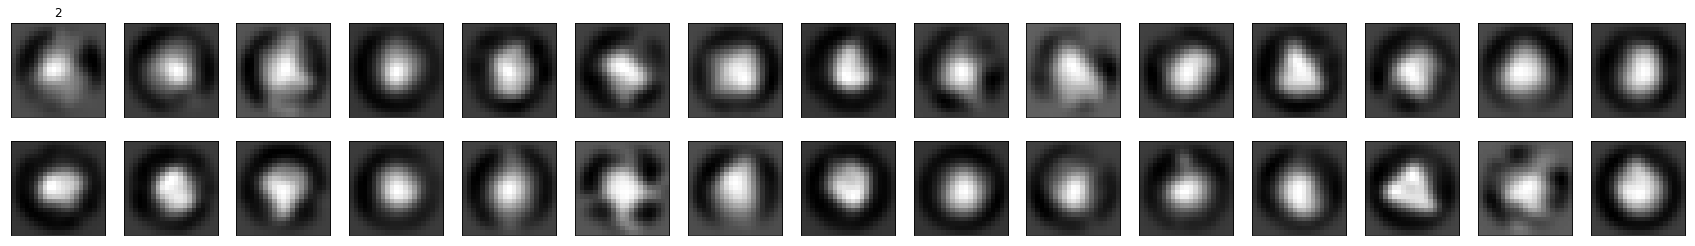

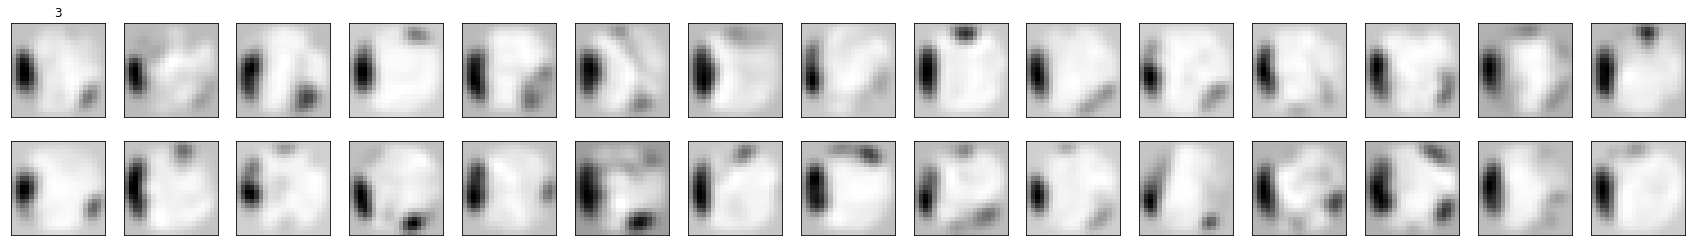

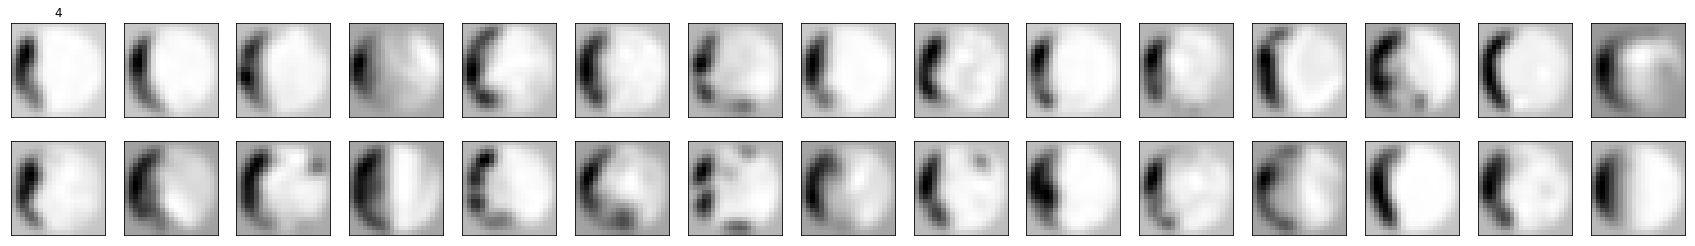

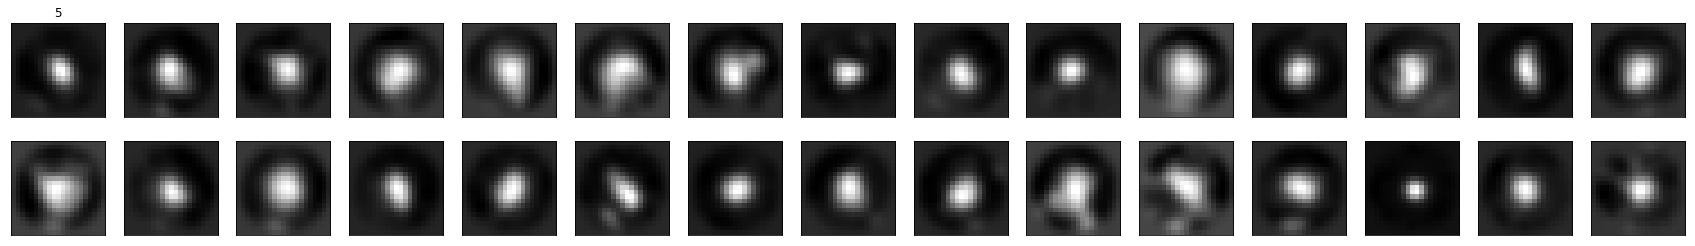

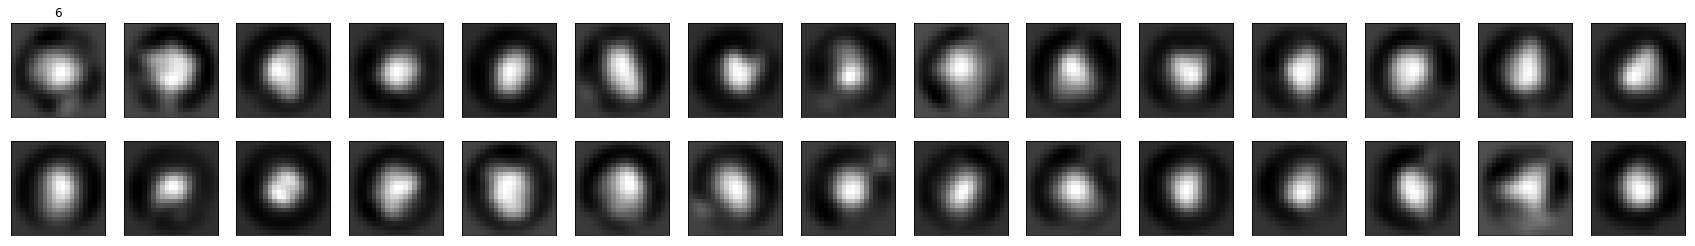

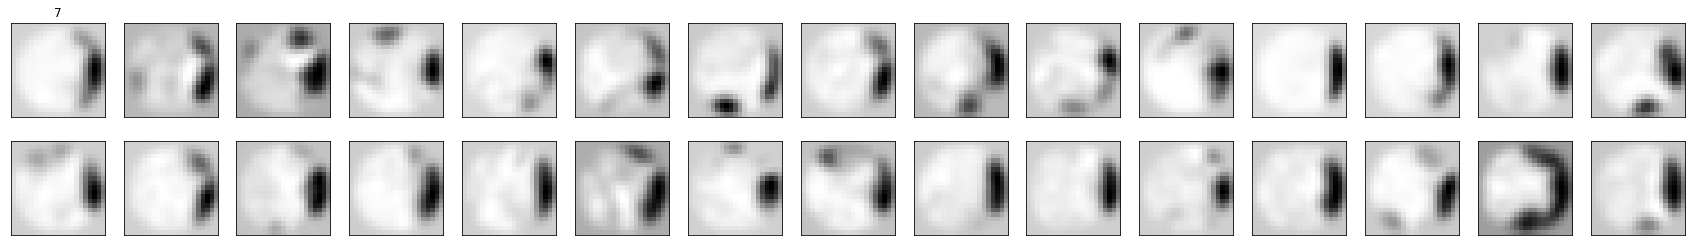

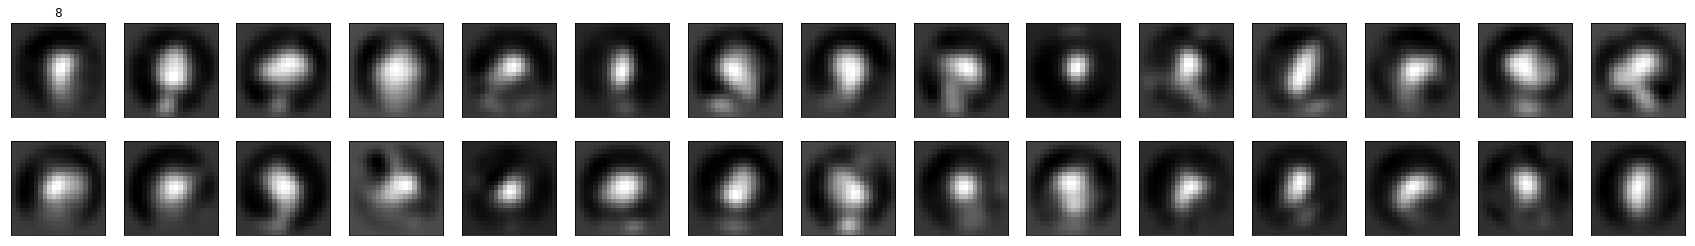

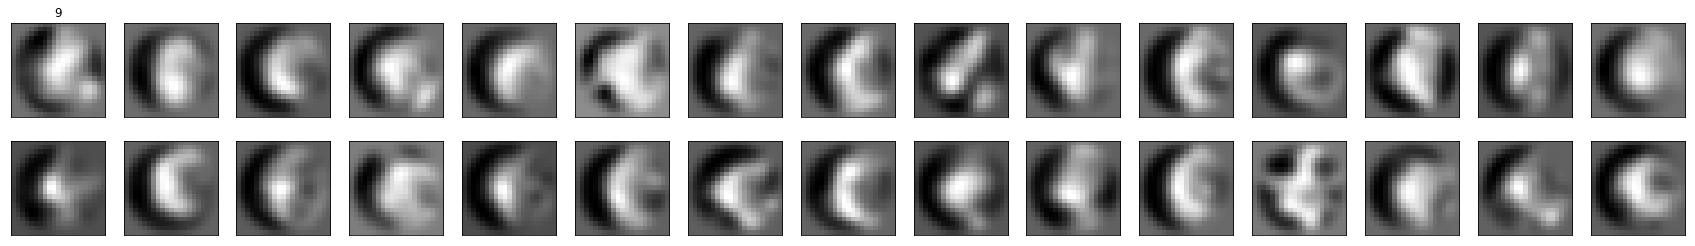

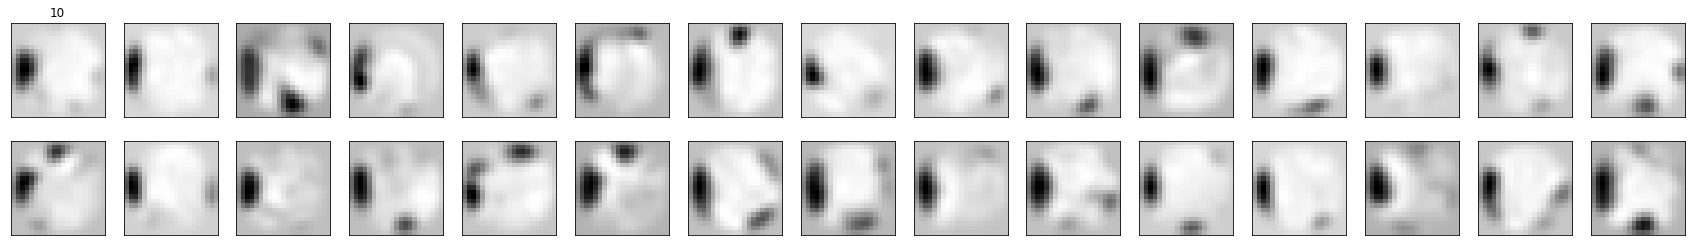

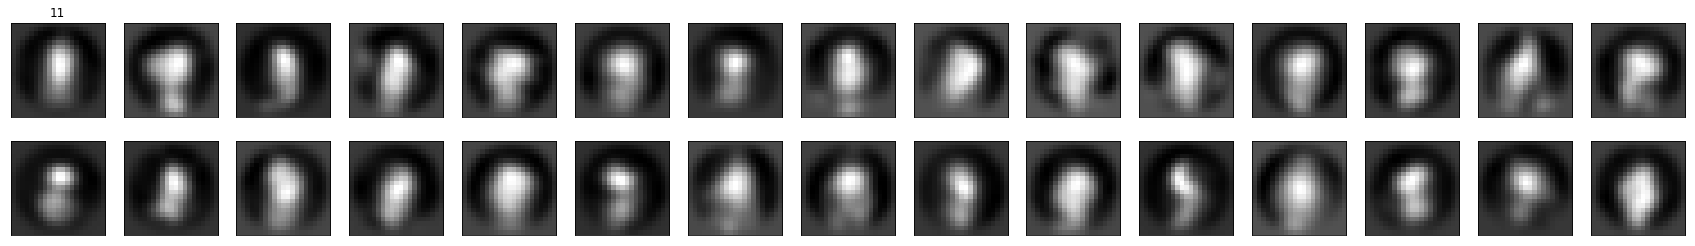

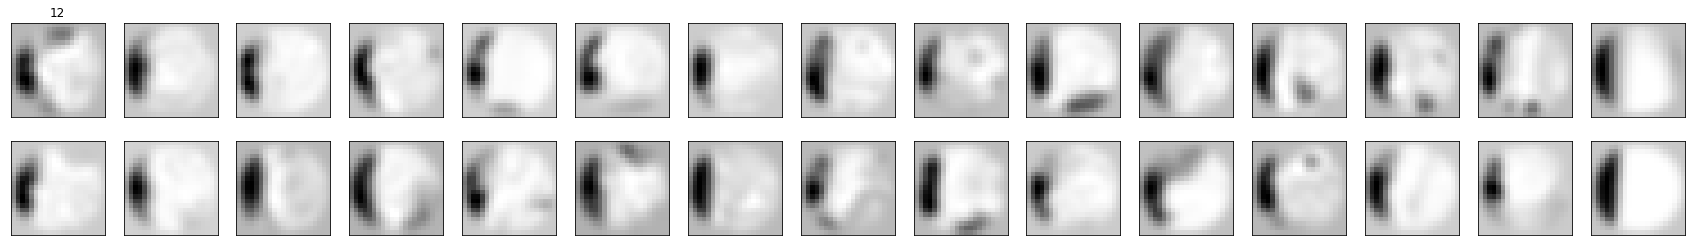

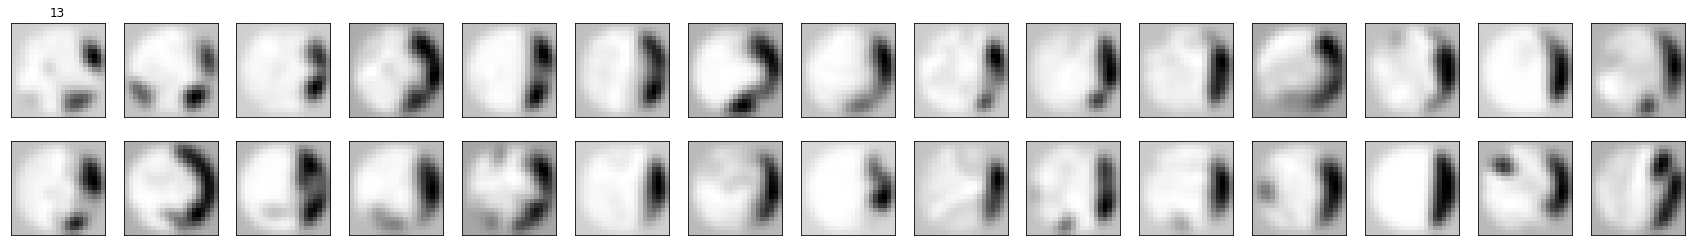

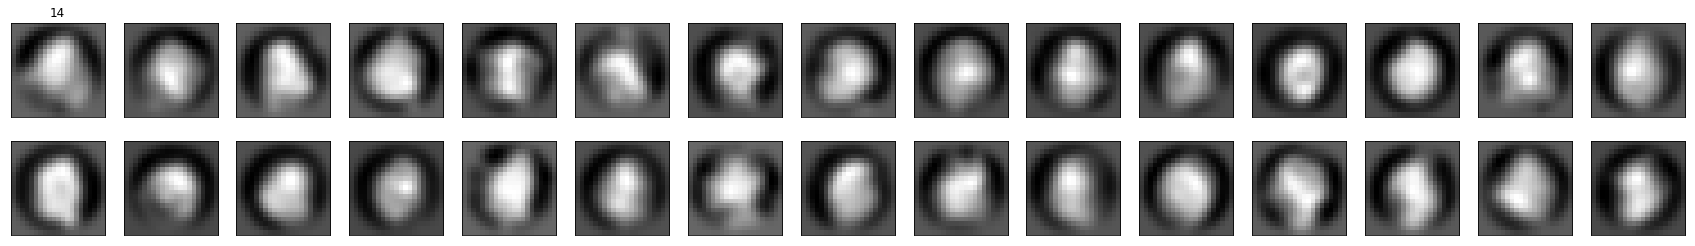

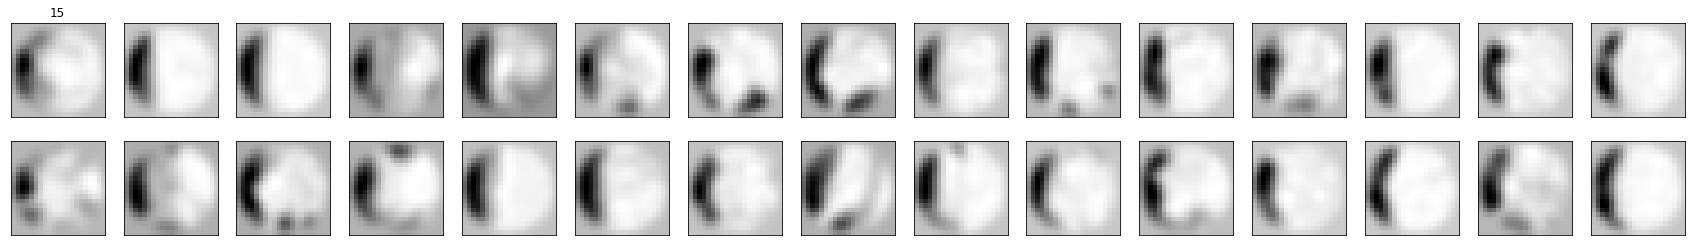

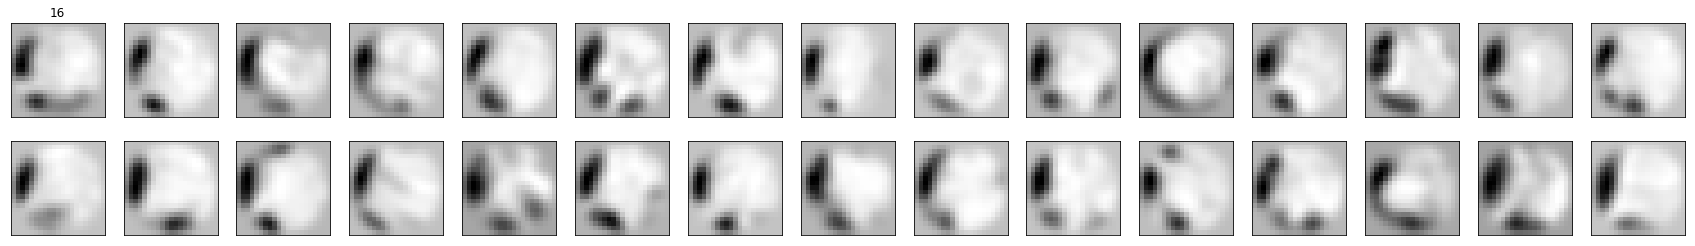

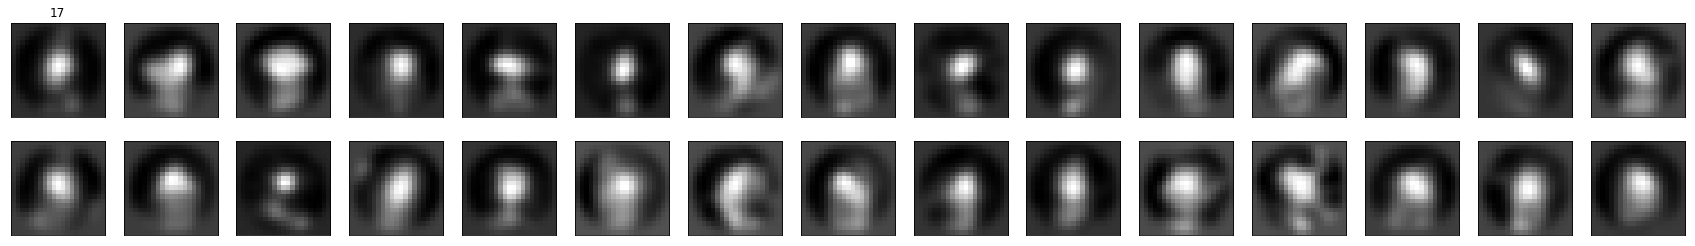

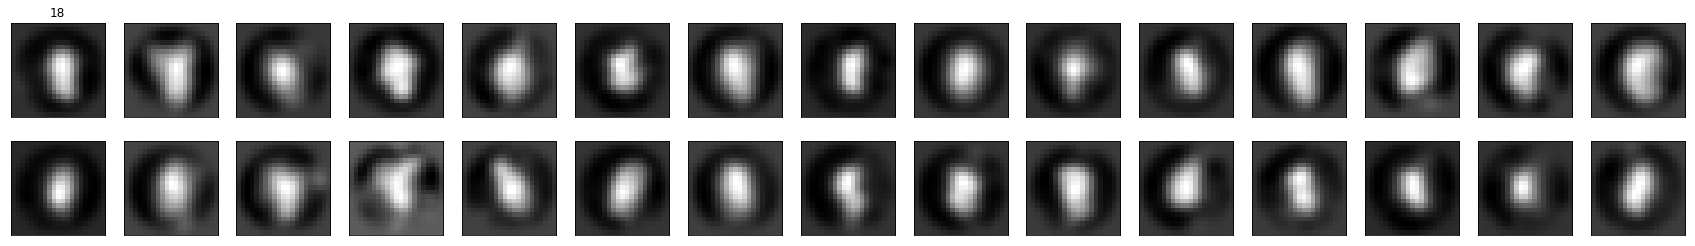

In [69]:
size=6000
core_sets={x[0]:[] for x in c.items() if x[1]>size}
print(len(core_sets))

[x for x in c.items() if x[1]>size]

lcombined.shape[0]/(3**8)

for i in range(len(all_labels)):
    vec=all_labels[i][:K1]
    if i%1000 == 0:
        print('\r',i,end='')
    if vec in core_sets:
        core_sets[vec].append(i)
        #print(vec,core_sets[vec])

len(all_labels),lcombined.shape
print()
i=0
for key in core_sets.keys():
    data=lcombined[core_sets[key],:,:]
    print(i,key,data.shape)
    plot_patches(data,h=2,_titles=[str(i)])
    i+=1

## finding neighborhoods in the coding graph

In [70]:
len(c)

26280

In [71]:
cells=list(c.items())
cells=sorted(cells,key=lambda x:x[1],reverse=True)
cells[:10]

[((1, 9, 0, 3, 9, 7, 2), 41987),
 ((7, 3, 8, 0, 7, 0, 3), 28874),
 ((1, 9, 0, 3, 9, 9, 2), 27841),
 ((8, 1, 4, 7, 0, 5, 1), 19416),
 ((5, 9, 0, 3, 9, 9, 2), 18362),
 ((8, 1, 4, 7, 0, 5, 6), 12594),
 ((7, 3, 8, 8, 7, 0, 3), 10888),
 ((5, 4, 0, 9, 2, 1, 8), 10608),
 ((1, 0, 0, 3, 9, 7, 2), 10518),
 ((5, 9, 0, 3, 9, 9, 4), 9901)]

In [72]:
def hamming(a,b):
    assert len(a)==len(b)
    d=0
    for i in range(len(a)):
        if a[i]!=b[i]:
            d+=1
    return d

clusters=[[[x]] for x in c.items() if x[1]>size]
for cluster in clusters:
    last_layer=cluster[-1]
    #print('last_layer=',last_layer)
    new_layer=[]
    for x in c.items():
        new_key=x[0]
        for e in last_layer:
            #print(e,new_key)
            if hamming(e[0],new_key)<2:
                new_layer.append(x)
    cluster.append(new_layer)
            
        
            
            
    

In [73]:
layers=[set([x[0] for x in cluster[1]]) for cluster in clusters]
L=len(layers)
Count=np.zeros([L,L])
for i in range(len(layers)-1):
    for j in range(i+1,len(layers)):
        Count[i,j]=len(layers[i] & layers[j])
        Count[j,i]=len(layers[i] & layers[j])

print('   ',''.join(['%3d'%l for l in range(L)]))
for i in range(L):
    print('%3d'%i,''.join(['%3d'%l for l in Count[i,:]]))

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
  0   0  0  0  0  0  0  2  0  0  4  0  0  0  0  0  0  0  0  2
  1   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0
  2   0  0  0  2  0  7  0  0  0  0  0  0  0  5  0  0  0  0  0
  3   0  0  2  0  0  4  0  0  2  0  2  0  0  0  6  0  0  0  0
  4   0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  6  0  0  0
  5   0  0  7  4  0  0  0  0  0  0  0  0  0  2  2  0  0  0  0
  6   2  0  0  0  2  0  0  0  0  5  0  0  0  0  0  0  0  0  0
  7   0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0
  8   0  0  0  2  0  0  0  0  0  0  2  0  0  0  5  0  0  0  0
  9   4  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0
 10   0  0  0  2  0  0  0  0  2  0  0  0  0  0  4  0  0  0  0
 11   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 12   0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0
 13   0  0  5  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
 14   0  0  0  6  0  2  0  0  5  0  4  0  0  0  0  0  0  0  0
 15   0 

In [74]:
for i in range(len(clusters)):
    total=sum([x[1] for x in clusters[i][1]])
    print(clusters[i][0],total)

[((8, 1, 4, 7, 4, 5, 6), 8818)] 34302
[((1, 0, 0, 3, 2, 1, 9), 6961)] 28669
[((5, 9, 0, 3, 9, 9, 4), 9901)] 47997
[((1, 9, 0, 3, 9, 9, 2), 27841)] 93904
[((9, 1, 4, 7, 0, 2, 1), 7844)] 27894
[((5, 9, 0, 3, 9, 9, 2), 18362)] 65057
[((8, 1, 4, 7, 0, 5, 1), 19416)] 44784
[((7, 3, 8, 8, 7, 0, 3), 10888)] 42975
[((1, 0, 0, 3, 9, 7, 2), 10518)] 68552
[((8, 1, 4, 7, 0, 5, 6), 12594)] 49461
[((1, 9, 0, 3, 6, 7, 2), 6304)] 64657
[((4, 7, 7, 5, 3, 6, 7), 7472)] 19012
[((7, 3, 8, 0, 7, 0, 3), 28874)] 42909
[((5, 9, 0, 3, 2, 9, 4), 6853)] 32408
[((1, 9, 0, 3, 9, 7, 2), 41987)] 97767
[((9, 1, 4, 6, 0, 2, 1), 8595)] 29735
[((1, 0, 0, 3, 2, 1, 8), 8125)] 28468
[((5, 4, 0, 9, 2, 1, 8), 10608)] 30369
[((8, 6, 4, 6, 4, 5, 6), 6383)] 18719


In [75]:
#computing the mean
Multi_Rep[0][0].shape

(21, 21)

In [76]:
len(Multi_Rep[0])

10

In [78]:
len(Multi_Rep)

20

In [80]:
import pickle as pk
package={'Multi_rep':Multi_Rep,
       'clusters':clusters}
pk.dump(package,open('reps.pkl','wb'))

In [81]:
!ls -l

total 10848
-rw-rw-r-- 1 ubuntu ubuntu  242988 Oct  9 18:53 awsfiles.txt
-rw-rw-r-- 1 ubuntu ubuntu    1319 Oct  9 18:53 calculator.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  678870 Oct  9 20:43 Check extracted.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 1672514 Oct 11 06:12 Combine npz files.ipynb
-rw-rw-r-- 1 ubuntu ubuntu      53 Oct  9 18:53 echo.log
-rw-rw-r-- 1 ubuntu ubuntu 1189339 Oct 14 07:04 Entropy Based Analysis 1.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  151356 Oct  9 18:53 files.txt
-rw-rw-r-- 1 ubuntu ubuntu 2259598 Oct 10 02:12 Finding cell in window.ipynb
-rw-rw-r-- 1 ubuntu ubuntu       0 Oct  9 18:53 flag
-rw-rw-r-- 1 ubuntu ubuntu 1641494 Sep 10 21:49 generate Normalized Patches.ipynb
-rw-rw-r-- 1 ubuntu ubuntu    5722 Sep 10 21:49 initial exploration, generated window.pkl.ipynb
-rw-rw-r-- 1 ubuntu ubuntu      60 Oct  9 18:53 log
-rw-rw-r-- 1 ubuntu ubuntu   66640 Oct  9 18:53 ManageEC2Jobs.ipynb
-rw-rw-r-- 1 ubuntu ubuntu    8196 Oct  9 18:53 manage s3 lock files.ipynb
-rw-rw-r-- 1 ubuntu ubu

In [85]:
!aws s3 cp  reps.pkl s3://mousebraindata-open/MD657/patches/reps.pkl

upload: ./reps.pkl to s3://mousebraindata-open/MD657/patches/reps.pkl


In [86]:
!aws s3 ls s3://mousebraindata-open/MD657/patches/

2018-10-09 21:42:43 1447758130 patches0.npz
2018-10-09 21:43:25 1291505818 patches1.npz
2018-10-09 21:49:28 1380666058 patches10.npz
2018-10-09 22:50:51 1613961962 patches100.npz
2018-10-09 22:51:32 1445337490 patches101.npz
2018-10-09 22:52:11 1331715338 patches102.npz
2018-10-09 22:52:54 1441007234 patches103.npz
2018-10-09 22:53:33 1258504426 patches104.npz
2018-10-09 22:54:12 1248270498 patches105.npz
2018-10-09 22:54:45 1095070882 patches106.npz
2018-10-09 22:55:21 1178394690 patches107.npz
2018-10-09 22:55:55 1173378586 patches108.npz
2018-10-09 22:56:29 1077951578 patches109.npz
2018-10-09 21:50:05 1285171810 patches11.npz
2018-10-09 22:57:03 1051647290 patches110.npz
2018-10-09 22:57:46 1480947794 patches111.npz
2018-10-09 22:58:30 1420741098 patches112.npz
2018-10-09 22:59:14 1293173370 patches113.npz
2018-10-09 23:00:01 1283181506 patches114.npz
2018-10-09 23:00:45 1134285250 patches115.npz
2018-10-09 23:01:28 1339219322 patches116.npz
2018-10-09 23:02:10 1232522890 patches11